In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np


from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")
RADARHD_MODEL_STATE_DICT_PATH=os.getenv("RADARHD_MODEL_STATE_DICT_PATH")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS

from mmwave_model_integrator.encoders.radarhd_encoder import RadarHDEncoder
from mmwave_model_integrator.model_runner.radarhd_runner import RadarHDRunner
from mmwave_model_integrator.decoders.radarhd_decoder import RadarHDDecoder

from mmwave_model_integrator.plotting.plotter_rng_az_to_pc import PlotterRngAzToPC
from mmwave_model_integrator.plotting.movies_rng_az_to_pc import MovieGeneratorRngAzToPC


In [2]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadarHD.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

#load the dataset
dataset_name = "cpsl_RadarHD"
dataset_path = os.path.join(DATASET_PATH,"radarHD_comp_datasets",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full"
)

did not find radar samples
did not find lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
did not find vehicle velocity samples


In [3]:
plotter = PlotterRngAzToPC()

encoder = RadarHDEncoder(
    config_manager=cfg_manager,
    range_max=10.8,
    num_range_bins=256,
    mag_threshold=0.05,
    num_az_angle_bins=64
)

runner = RadarHDRunner(
    state_dict_path=RADARHD_MODEL_STATE_DICT_PATH,
    cuda_device="cuda:0"
)

decoder = RadarHDDecoder(
    max_range_m=10.8,
    num_range_bins=256,
    num_angle_bins=512
)

movie_generator = MovieGeneratorRngAzToPC(
    cpsl_dataset=dataset,
    plotter=plotter,
    range_az_encoder=encoder,
    model_runner=runner,
    lidar_pc_polar_decoder=decoder,
    temp_dir_path=os.getenv("MOVIE_TEMP_DIRECTORY")
)

_ModelRunner: using GPU: cuda:0
found temp dir: /home/david/Downloads/radnav_temp_dir
clearing temp directory /home/david/Downloads/radnav_temp_dir


In [4]:
#encode 40 frames before the first encoding is available
for i in range(encoder.num_frames_history + 1):

    adc_cube = dataset.get_radar_data(idx=i)
    encoded_data = encoder.encode(adc_cube)

pred = runner.make_prediction(encoded_data)
pc_cart = decoder.convert_polar_to_cartesian(
    decoder.decode(pred)
)

AssertionError: No radar dataset loaded

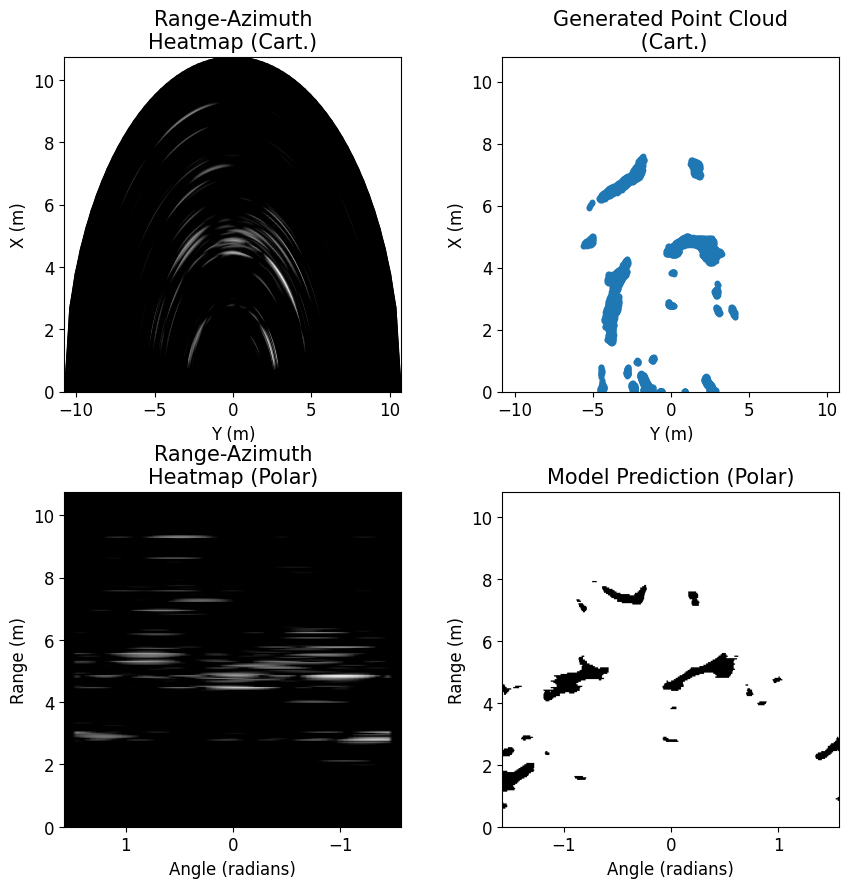

In [ ]:
plotter.plot_compilation(
    adc_cube=adc_cube,
    range_az_encoder=encoder,
    model_runner=runner,
    lidar_pc_polar_decoder=decoder,   
)

100%|██████████| 303/303 [00:11<00:00, 25.91it/s]


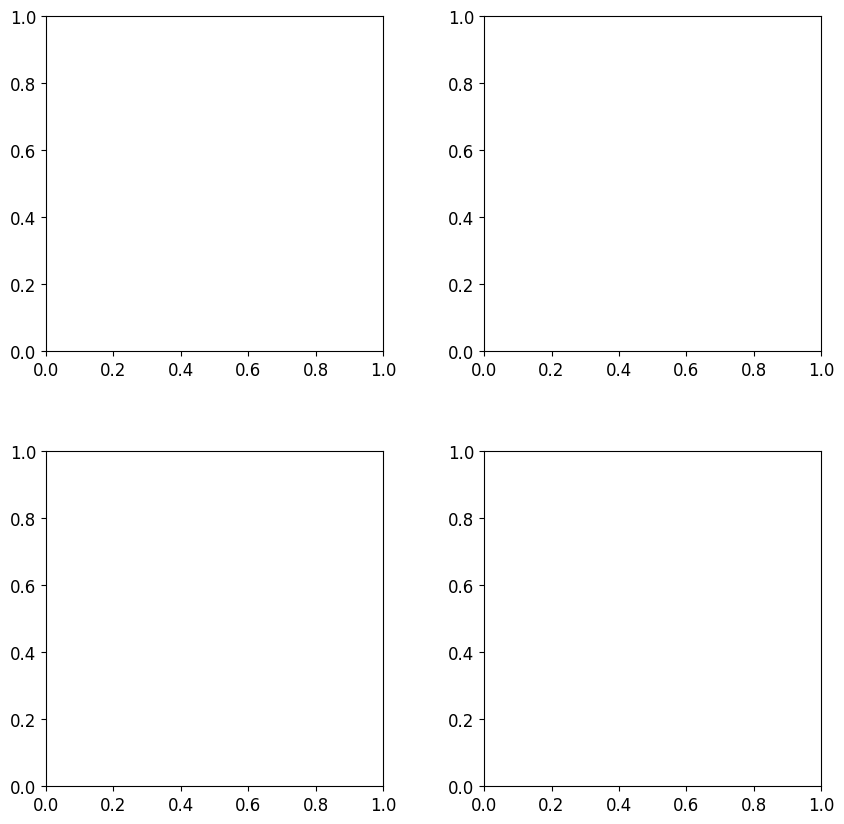

In [9]:
#reset the encoder
encoder = RadarHDEncoder(
    config_manager=cfg_manager,
    range_max=10.8,
    num_range_bins=256,
    mag_threshold=0.05,
    num_az_angle_bins=64
)

#generate the movie
movie_generator.initialize_figure(
    nrows=2,
    ncols=2,
    figsize=(10,10),
    wspace=0.3,
    hspace=0.3
)

movie_generator.generate_movie_frames()

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}.mp4".format(dataset_name),fps=fps)